In [329]:
import pandas as pd
commodity = 'corn'
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch

In [330]:
# note: edited 12/30/2015

In [331]:
import dataloader_cm
import LSTM

In [332]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [395]:
    # read csvs and combine into single dataframe
read_csv = pd.read_csv(f'data/commodities.csv', header = 0)

In [396]:
[x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')]

['_BCOMD_Close',
 'CMECFODM_Close',
 '__CC1_ID_Vol',
 '__SC1_ID_Close',
 '__SC1_ID_Vol',
 '__C_US2D_Close',
 '__WTC_D_Close',
 '_BO1599D_Close',
 '__SYB_TD_Close',
 'BRT_D_Close',
 'CMCORNM_Close',
 'CMSCORNM_Close']

In [417]:
testdl = dataloader_cm.CommoditiesExogenousDataSet(filepath='commodities', seq_length= 20, split = 'train', pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

In [424]:
tnew = LSTM.CommodityLSTM(num_features = testdl[0][0].shape[1])

In [433]:
tnew.forward(testdl[0][0].unsqueeze(0).float())

(tensor([[0.1667]], grad_fn=<AddmmBackward0>),
 tensor([[0.5416]], grad_fn=<SigmoidBackward0>))

In [457]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length= 5, split = 'train', batch_size = 2, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

In [498]:
for step, batch in enumerate(train_loader):
    X, y = batch
    break

In [514]:
yn = y.unsqueeze(-1)
yn = yn.float()
yn

tensor([[[ 1.0000],
         [ 0.0074]],

        [[ 0.0000],
         [-0.0095]]])

In [504]:
yn.shape

torch.Size([2, 2, 1])

In [494]:
X.shape

torch.Size([2, 5, 13])

In [502]:
nn_output.shape

torch.Size([2, 1])

In [521]:
yn[:, 1, :]

tensor([[ 0.0074],
        [-0.0095]])

In [522]:
import torch.nn as nn

nn_output, logit = tnew.forward(X.float())

mseloss = nn.MSELoss()
bceloss = nn.BCELoss()

batch_loss = mseloss(nn_output, yn[:, 1, :])
classification_loss = bceloss(logit, yn[:, 0, :])
totalloss = batch_loss + classification_loss

In [523]:
batch_loss

tensor(0.0186, grad_fn=<MseLossBackward0>)

In [520]:
classification_loss

tensor(0.6892, grad_fn=<BinaryCrossEntropyBackward0>)

# MULTI TASK

In [557]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

testlstm = LSTM.CommodityLSTM(num_features = 13, )
train_losses, _ = testlstm.train(train_loader, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.7684251666069031
TRAINING BATCH LOSS AT STEP 700: 0.6868513822555542


 20%|██        | 1/5 [00:16<01:04, 16.17s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6932423710823059
TRAINING BATCH LOSS AT STEP 700: 0.7033482193946838


 40%|████      | 2/5 [00:33<00:50, 16.98s/it]

TRAINING BATCH LOSS AT STEP 0: 0.7015630602836609
TRAINING BATCH LOSS AT STEP 700: 0.7061594724655151


 60%|██████    | 3/5 [00:49<00:32, 16.50s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6931735277175903
TRAINING BATCH LOSS AT STEP 700: 0.6925539374351501


 80%|████████  | 4/5 [01:05<00:16, 16.25s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6861972808837891
TRAINING BATCH LOSS AT STEP 700: 0.6849244832992554


100%|██████████| 5/5 [01:20<00:00, 16.10s/it]


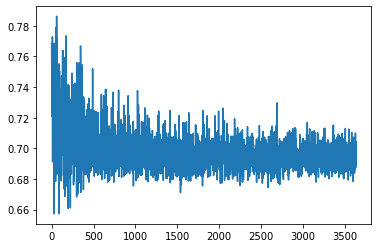

In [558]:
plt.plot([x.detach().numpy() for x in train_losses])

In [564]:
def validate_model(model, split='val', seq_length = 30):
    from torch.utils.data import dataset, dataloader, SequentialSampler
    dl = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length= seq_length, split = split, batch_size = 1, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')


    predictions, val_losses, actuals = model.test(dl)
    predictions = predictions.flatten()
    actuals = np.array(actuals)

    from backtester import backtest_log
    scaled_returns, actual_returns, strategy_predictors = backtest_log(predictions, actuals)
    return scaled_returns, actual_returns, strategy_predictors

AVERAGE LOSS:  0.69399
Long only annualized psuedo sharpe:  0.047245367810432544
Strategy annualized psuedo sharpe:  0.5424821098023596
Correlation matrix between strategy predictors and returns
[[1.         0.04802418]
 [0.04802418 1.        ]]
Avg. Portfolio Allocation,  0.03162249
Percent of time predicted direction correctly:  47.18900343642612
Percent of time long:  45.786941580756015


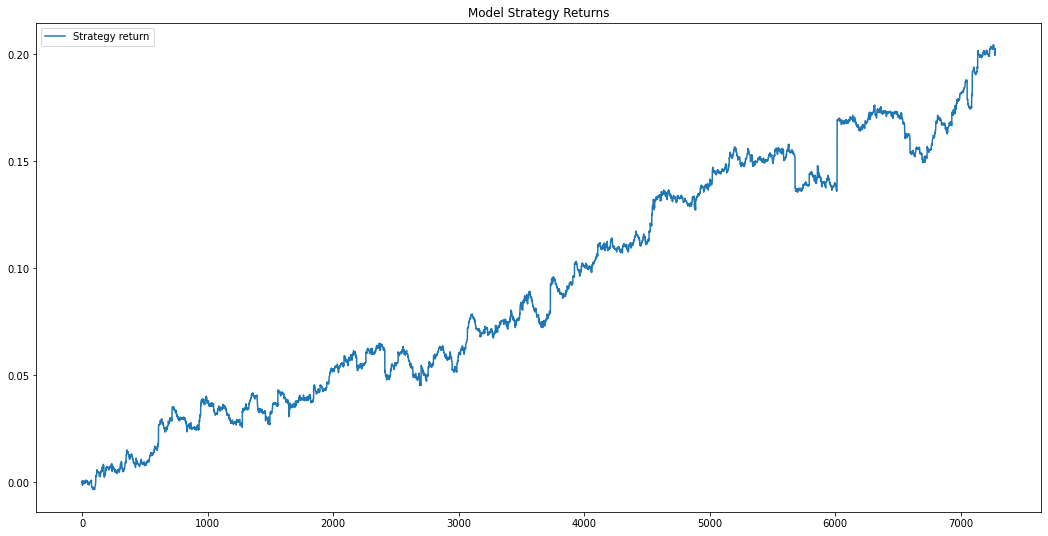

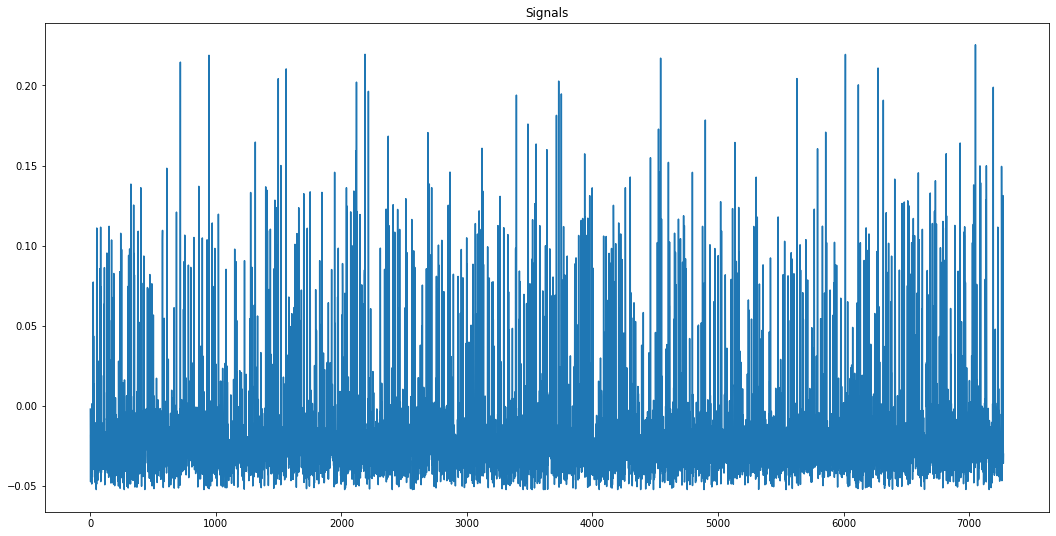

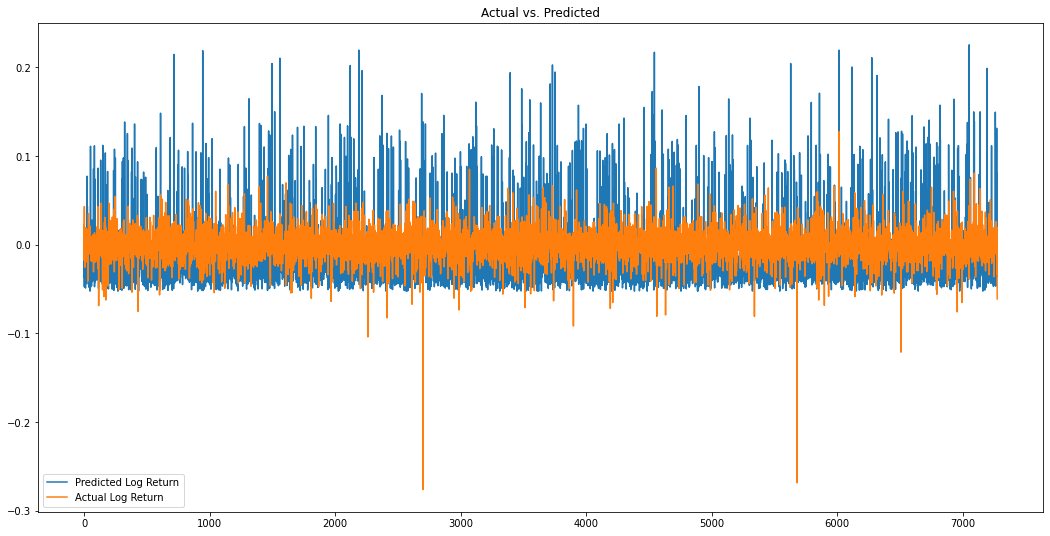

In [572]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train')

In [573]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.335
Date:                Sun, 28 Nov 2021   Prob (F-statistic):             0.0374
Time:                        19:34:26   Log-Likelihood:                 19548.
No. Observations:                7275   AIC:                        -3.909e+04
Df Residuals:                    7273   BIC:                        -3.908e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.859      0.390      -0.000       0.001
x1            -4.1003      1.969     -2.082      0.037      -7.960      -0.240
==============================================================================
Omnibus:                     2963.407   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           440507.018
Skew:                          -0.889   Prob(JB):                         0.00
Kurtosis:                      41.080   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

AVERAGE LOSS:  0.69526595
Long only annualized psuedo sharpe:  0.0735615363807346
Strategy annualized psuedo sharpe:  1.7465626244459007
Correlation matrix between strategy predictors and returns
[[1.         0.15487047]
 [0.15487047 1.        ]]
Avg. Portfolio Allocation,  0.040782213
Percent of time predicted direction correctly:  46.00760456273764
Percent of time long:  41.06463878326996


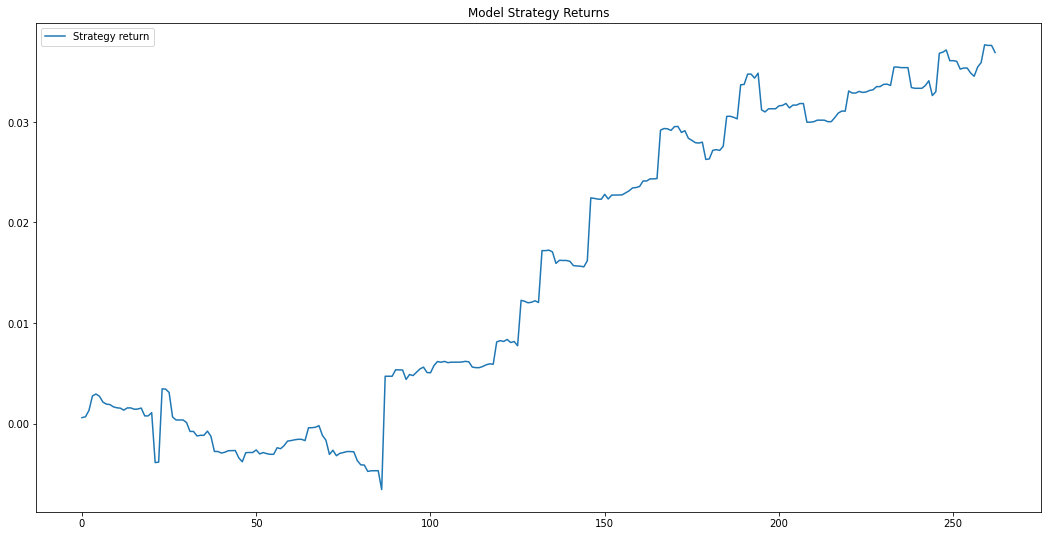

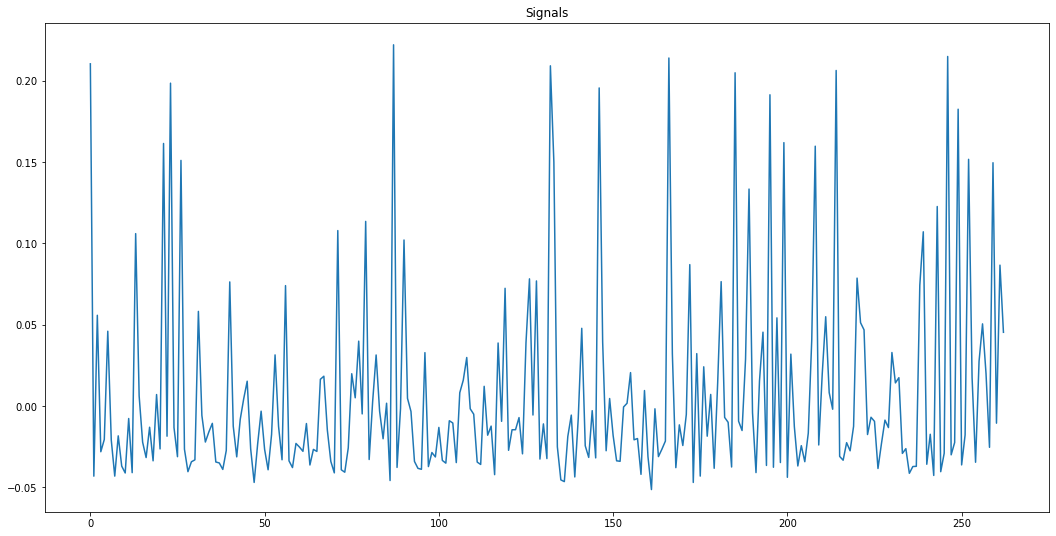

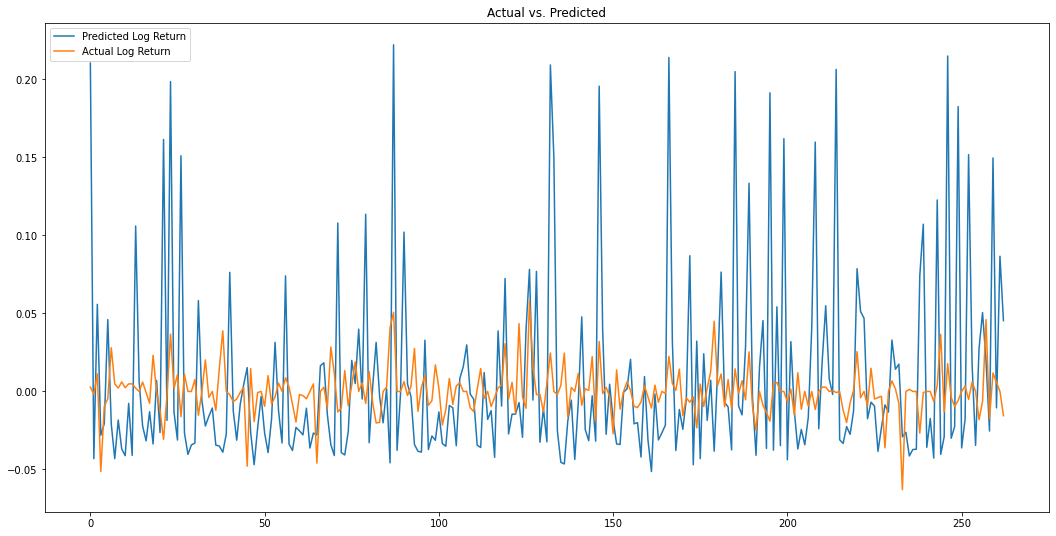

In [570]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test')

In [571]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     17.86
Date:                Sun, 28 Nov 2021   Prob (F-statistic):           3.29e-05
Time:                        19:29:13   Log-Likelihood:                 743.94
No. Observations:                 263   AIC:                            -1484.
Df Residuals:                     261   BIC:                            -1477.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.524      0.600      -0.002       0.001
x1             3.4184      0.809      4.226      0.000       1.833       5.004
==============================================================================
Omnibus:                       35.106   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.140
Skew:                          -0.073   Prob(JB):                     7.15e-53
Kurtosis:                       7.679   Cond. No.                         784.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

# NON MULTI TASK WITH EXOGENOUS

In [ ]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

testlstm = LSTM.CommodityLSTM(num_features = 13, )
train_losses, _ = testlstm.train(train_loader, epochs = 5)

# ONE TIME SERIES